In [2]:
import sys
from pathlib import Path
import os
import numpy as np
from tb_hamiltonian import TBHamiltonian

from tb_hamiltonian.potentials import PotentialFactory
from tb_hamiltonian.utils import get_structure

sys.tracebacklimit = None

# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

new_path = '/scratch/snx3000/ajayaraj/tests/periodic-potential/daint/BLG/tb-hamiltonian'
os.chdir(new_path)


In [3]:
nn = 1  # number of nearest neighbors | don't use 0!

workdir = Path(".")

# lengths
lx = 153  # length in x direction (Å)
ly = lx / np.sqrt(3)   # length in y direction (Å) keeping the b/a ratio
lz = 10  # length in z direction (Å)
basepath = workdir / f"len_{lx}x{round(ly,3)}/nn_{nn}"

# or, repetitions
# nx = 3  # number of repetitions in x direction
# ny = 3  # number of repetitions in y direction
# nz = 1  # number of repetitions in z direction
# basepath = workdir / f"rep_{nx}x{ny}/nn_{nn}"

basepath.mkdir(parents=True, exist_ok=True)


In [4]:
# Define structure

structure = get_structure(
    unit_cell_filepath=workdir / "POSCAR",  # local unit cell file
    lengths=(lx, ly, lz),
    # repetitions=(nx, ny, nz),
    # structure_filepath=f"{basepath}/POSCAR"
)

structure.info["label"] = "BLG"  # will show up at top of Hamiltonian output file
structure.write(basepath / "POSCAR", format="vasp")


In [5]:
# Compute H

H = TBHamiltonian(
    structure=structure,
    nearest_neighbor=nn,
    distances=(0.0, 1.425, 2.468, 2.850),
    hopping_parameters=(0.0, -2.7, 0.0, -0.27),
    interlayer_coupling=0.33,
)

H.build()

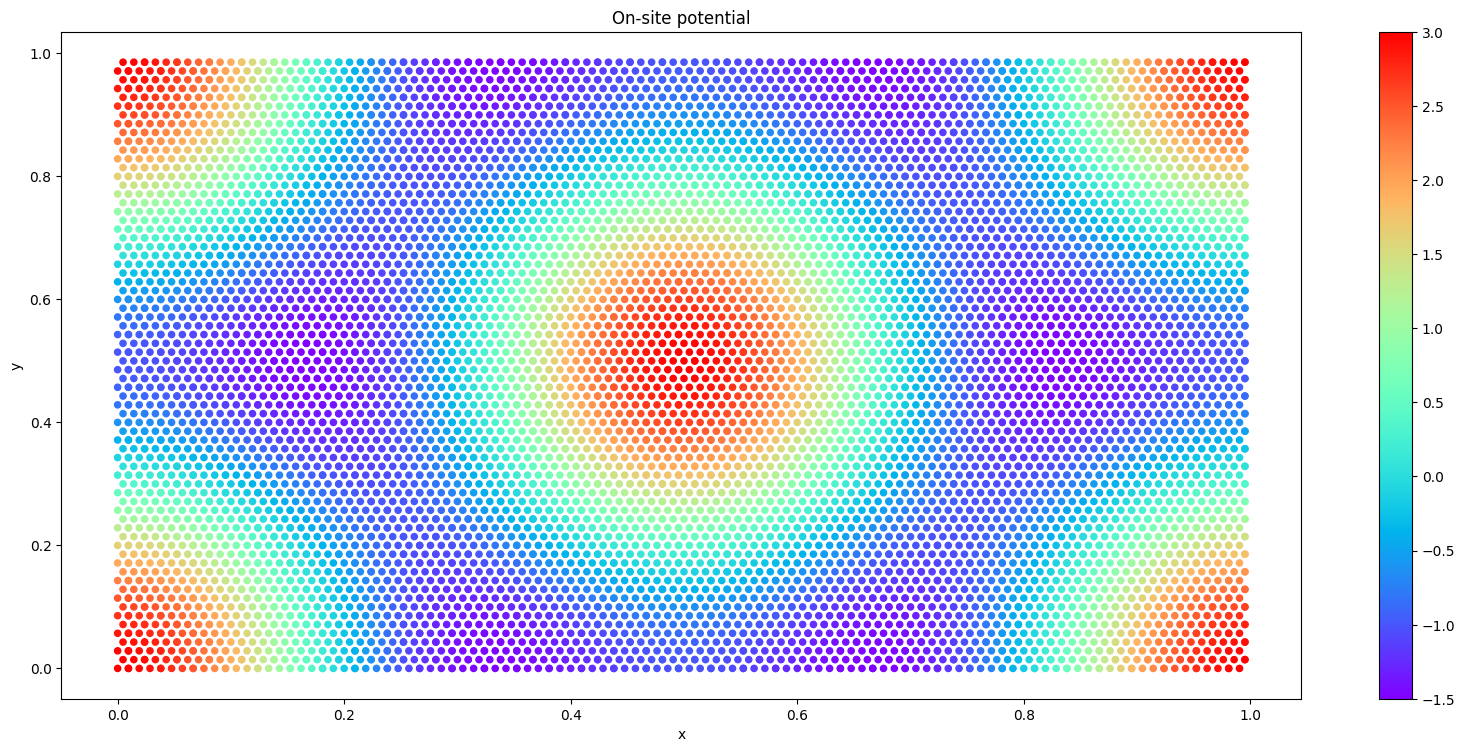

In [6]:
potential = PotentialFactory("superlattice")
Rx = 20
Ry = Rx/(1.33333 * np.sqrt(3))
m = 1
factor = 4 * m * np.pi
qvalue1 = factor
qvalue2 = factor / np.sqrt(3)
potential.params = {
    "amplitude": 1.0,
    "qvalue1": qvalue1,
    "qvalue2": qvalue2,
}
H.update_onsite_terms(
    onsite_term=0.0,
    potential=potential,
    alpha=(1.0, 1.0),
)
H.plot_potential(fig_params={"figsize":(Rx,Ry)})

In [7]:
amplitude = 1
Lx = 1
Ly = 1

def calculate_V(x, y, qvalue1, qvalue2, amplitude):
    V = 0.0
    for n in range(1, 7):
        angle = 2 * n * np.pi / 6
        V += np.cos((qvalue1 * np.cos(angle) * x + qvalue2 * np.sin(angle) * y))
    V *= amplitude / 2
    return V

# Coordinates to evaluate
coordinates = [
    (0, 0),
    (Lx, 0),
    (0, Ly),
    (Lx, Ly)
]

# Calculate and print V for each coordinate
for x, y in coordinates:
    V = calculate_V(x, y, qvalue1, qvalue2, amplitude)
    print(f"V({x}, {y}) = {V}")


V(0, 0) = 3.0
V(1, 0) = 3.0
V(0, 1) = 3.0
V(1, 1) = 3.0


In [8]:
import numpy as np

# Define the parameters
amplitude = 1
Lx = 1
Ly = 1

def calculate_V(x, y, qvalue1, qvalue2, amplitude):
    V = 0.0
    for n in range(1, 7):
        angle = 2 * n * np.pi / 6
        V += np.cos((qvalue1 * np.cos(angle) * x + qvalue2 * np.sin(angle) * y))
    V *= amplitude / 2
    return V

# Define the atomic coordinates (from POSCAR or another source)
# For example, let's say these are the atomic coordinates within the unit cell
atomic_coordinates = [
    (0, 0),
    (Lx / 2, Ly / 2),
    (Lx / 3, Ly / 3)
]

# Check periodic boundary conditions
pbc_satisfied = True

for x, y in atomic_coordinates:
    # Calculate potential at (x, y)
    V_origin = calculate_V(x, y, qvalue1, qvalue2, amplitude)

    # Calculate potential at equivalent points under PBC
    V_pbc1 = calculate_V(x + Lx, y, qvalue1, qvalue2, amplitude)
    V_pbc2 = calculate_V(x, y + Ly, qvalue1, qvalue2, amplitude)
    V_pbc3 = calculate_V(x + Lx, y + Ly, qvalue1, qvalue2, amplitude)

    # Check if potentials match
    if not (np.isclose(V_origin, V_pbc1) and np.isclose(V_origin, V_pbc2) and np.isclose(V_origin, V_pbc3)):
        print(f"PBC not satisfied at (x, y) = ({x}, {y})")
        pbc_satisfied = False

if pbc_satisfied:
    print("Periodic boundary conditions are satisfied for all atomic coordinates.")
else:
    print("Periodic boundary conditions are NOT satisfied.")


Periodic boundary conditions are satisfied for all atomic coordinates.
